In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

import pandas as pd
# from SpringRank import SpringRank

from matplotlib import pyplot as plt

from scipy.optimize import root, minimize, approx_fprime
from scipy.optimize.slsqp import approx_jacobian
from itertools import product

from autograd import jacobian


import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

In [2]:
def compute_gamma(s, beta):
    gamma = np.exp(beta*s)
    gamma = gamma/gamma.sum()
    return(gamma)

def make_s(s_1, s_2, n_1, n):
        
    s_1 = s_1
    s_2 = s_2
    
    n_1 = int(n_1)
    n_2 = n - n_1
    
    s = np.zeros(n)
    s[0:n_1] += 1*s_1
    s[n_1:n] += 1*s_2
    return(s)

def make_gamma(s_1, s_2, n_1, n, beta):
    s = make_s(s_1, s_2, n_1, n)

    return(compute_gamma(s, beta)) # for root-degree score

In [3]:
df_SR = pd.read_csv('numerics/data_n_8.csv',
                   names=["n_1", "n_2", "beta", "s_1", "s_2"]) # springRank
padding = pd.DataFrame(
    list(product(np.linspace(0,2, 21),
    [0], 
    [0], 
    [8],
                 [0],
    [1])),
    columns = ['beta', 's_1', 's_2', 'n_1', 'n_2', 'group']
)
df_SR = pd.concat((padding, df_SR), axis = 0)

# need to pad to add unstable egalitarian solution

padding = pd.DataFrame(
    list(product(np.linspace(2,10, 21),
    [0], 
    [0], 
    [8], 
                 [0],
    [1])),
    columns = ['beta', 's_1', 's_2', 'n_1', 'n_2', 'group']
)

df_SR = pd.concat((padding, df_SR), axis = 0, sort=True)

/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [4]:
max(df_SR.n_1)

8

In [5]:
n = 8
m = 1
alpha = 10**(-5)

# likely need to troubleshoot this, esp. copies of n^{-1} and sign errors. 
# def f(s_1, s_2, n_1, n, beta):
    
#     s = make_s(s_1, s_2, n_1, n)
#     gamma = make_gamma(s_1, s_2, n_1, n, beta)
    
#     G = np.tile(gamma, (n,1))
#     L_G = 1.0/n*(np.eye(n) + np.diag(gamma) - (G + G.T))
    
#     out = -alpha*s - m*(1.0/n*L_G.dot(s) - (1.0/n*np.ones(n) - gamma))
    
#     return(out)

In [6]:
def f_(s, n, beta):
    
    gamma = compute_gamma(s, beta)
    
    G = np.tile(gamma, (n,1))
    L_G = (np.eye(n) + n*np.diag(gamma) - (G + G.T))
    
    out = alpha*s + (1.0/n*L_G.dot(s) + (1.0/n*np.ones(n) - gamma))
    
    return(out)

def jac_(s,  n, beta):
    J = np.zeros((n,n))
    for i in range(n):
        J[i,:] = approx_fprime(
            s, 
            f = lambda s: f_(s, n, beta)[i],
            epsilon=.0000001
        )
    return(J)

def restricted_jac(n, beta):
    """
    this one appears to check out. Note the normalizations
    """
    I = np.eye(n)
    E = np.ones((n,n))
    L_G = 2*(I - 1.0/n*E)
    return(alpha*I + (1/n*L_G - beta/n*(I - 1.0/n*E)))

In [7]:
def test_stable(s_1, s_2, n_1, n, beta):
    s = make_s(s_1, s_2, int(n_1), n)
    J = jac_(s, n, beta)
    eig = np.real(np.linalg.eig(J)[0]).min()
    return(eig>0)

In [8]:
df_SR['stable'] = df_SR.apply(lambda row: test_stable(row.s_1, row.s_2, row.n_1,  n, row.beta), axis = 1)
# _SR['test_f'] = df_SR.apply(lambda row: f(row.n_1, row.s_1, row.s_2, n, row.beta)[0], axis = 1)

In [9]:
df_SR.to_csv('throughput/springrank_score_curves.csv', index = False)

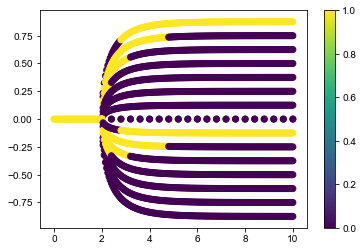

In [10]:
im = plt.scatter(df_SR.beta, df_SR.s_1, c = df_SR.stable>0)
im = plt.scatter(df_SR.beta, df_SR.s_2, c = df_SR.stable>0)
plt.colorbar(im)

/Users/philchodrow/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


n_1  group
1    -1       [Line2D(_line10)]
      1       [Line2D(_line11)]
2    -1       [Line2D(_line12)]
      2       [Line2D(_line13)]
3    -1       [Line2D(_line14)]
      3       [Line2D(_line15)]
4    -1       [Line2D(_line16)]
      4       [Line2D(_line17)]
5    -1       [Line2D(_line18)]
6    -1       [Line2D(_line19)]
7    -1       [Line2D(_line20)]
8    -1       [Line2D(_line21)]
dtype: object

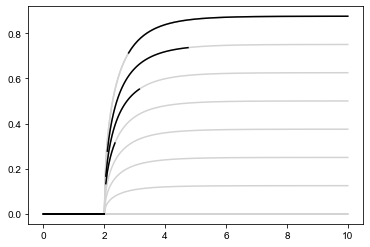

In [11]:
colors = ['lightgrey', 'black']
p = df_SR.groupby(['n_1']).apply(lambda g: plt.plot(g.beta, g.s_1, zorder = 1, color = "lightgrey"))

df_SR['group'] = df_SR.n_1
df_SR['group'][df_SR.beta<2.00001] = -1
df_SR[df_SR.stable].groupby(['n_1', 'group']).apply(lambda g: plt.plot(g.beta, g.s_1, zorder = 1, color = "black"))


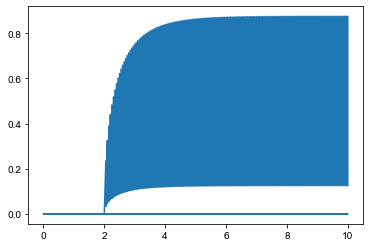

In [12]:
plt.plot(df_SR.beta, df_SR.s_1)
    